# 2-5. 数据整合

区别于我们以往所学的数据整合，在单细胞测序领域，数据整合涉及一个不得不去考虑的因素：样本的批次效应。

> **批次效应**
>
> 批次效应是测量的表达水平的变化，这是处理不同组或“批次”中的细胞的结果。例如，如果两个实验室从同一队列中采集样本，但这些样本的解离方式不同，则可能会出现批次效应。如果实验室 A 优化其解离方案以解离样品中的细胞，同时最大限度地减少对细胞的压力，而实验室 B 没有这样做，那么 B 组数据中的细胞很可能会表达更多与压力相关的基因。

一般来说，批次效应的来源多种多样且难以确定。一些批次效应来源可能是技术性的，例如样品处理、实验方案或测序深度的差异，但供体变异、组织或采样位置等生物效应也可以被解释为批次效应。是否应考虑生物因素带来的批次效应取决于实验设计和所提出的问题。例如我们在探究肿瘤与性别的关系的时候，那么性别就应当保留，而不是当成批次效应去除。

## 1. 数据整合模型的类别

在scRNA-seq中，消除批次效应往往由以下三个步骤构成：

- 降维
- 建模并消除批次效应
- 嵌入

降维在上一章的描述中，我们提到了主成分分析法PCA，运用PCA可以降低我们数据的信噪比，提取出细胞的差异信息。而建模并消除批次效应则是核心步骤，绝大多数的批次效应校正算法都包括了如何构建一个稳定的数学模型。我们按照模型的发展顺序，可以分为四类：**全局模型**，**线性嵌入模型**，**基于图的模型**，**深度学习模型**

- 全局模型: 源自bulk RNA-seq，将批次效应建模为所有细胞中存在的（加法/或乘法）效应。一个常见的例子是 ComBat
- 线性嵌入模型: 是第一个单细胞特异性批量去除方法。这些方法通常使用奇异值分解 (SVD) 的变体来嵌入数据，然后在嵌入中跨批次查找相似单元的局部邻域，并使用它们以局部自适应（非线性）方式校正批次效应。常见的例子包括最近邻MNN，Seurat，Harmony，Scanorama，FastMNN等
- 基于图的模型: 通常是运行速度最快的方法。使用最近邻域图来表示每个批次的数据。通过强制连接不同批次的细胞，然后修建细胞类型组成的差异的图的边缘，可以纠正批次效应。一个常见的例子是BBKNN
- 深度学习模型: 大多数深度学习批次效应校正方法都基于自动编码器网络，并且要么在条件变分自动编码器（CVAE）中对批量协变量进行降维，要么在嵌入空间中拟合局部线性校正。

![模型示例](https://www.sc-best-practices.org/_images/integration_overview_figure.jpeg)

## 2. 数据整合模型的比较

在本教程中，我们将运行不同的批次效应算法来学习批次效应校正的过程，但是不同算法的比较在此前的研究中已经完成。一些基准测试评估了批次效应校正和数据集成方法的性能。当消除样本的批次效应时，方法可能会过度校正并消除除批次效应之外的有意义的生物变异。因此，除了消除批次效应外，方法是否保留了潜在的生物学意义，也是我们需要去着重考虑的一个点。

**注意: 不存在适用于所有场景的最佳方法**

对于一些简单的批次效应校正任务来说，Seurat及Harmony的表现始终不错，而对于一些复杂的批次效应校正任务来说，scVI、scGen、scANVI和Scanorama则表现地更为出色。我们可以使用scib包来评估数据整合的效果，scib包中包含了10个指标，我们会在下面的探讨中详细介绍，让我们先导入我们的分析环境。

In [2]:
import omicverse as ov
print(f"omiverse version: {ov.__version__}")
import scanpy as sc
print(f"scanpy version: {sc.__version__}")
import scvi
print(f"scvi version: {scvi.__version__}")
import scib
print(f"scib version: {scib.__version__}")
ov.ov_plot_set()

omiverse version: 1.4.17
scanpy version: 1.9.1
scvi version: 0.20.3
scib version: 1.1.4


/mnt/data/env/pyomic/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


## 3. 导入数据

我们分析所用到的数据中包括了来自三个不同样本的骨髓数据，该数据集最早发布于2021年的[单细胞分析 NeurIPS 竞赛](https://openproblems.bio/neurips_2021/)。我们从中选择了我们选择了 s1d3、 s2d1和 s3d7的样本进行集成，数据可以从figshare下载

- s1d3: https://figshare.com/ndownloader/files/41932005
- s2d1: https://figshare.com/ndownloader/files/41932011
- s3d7: https://figshare.com/ndownloader/files/41932008

我们读取这三个数据，并进行合并。

In [3]:
#读取数据
adata1=ov.read('neurips2021_s1d3.h5ad')
adata1.obs['batch']='s1d3'
adata2=ov.read('neurips2021_s2d1.h5ad')
adata2.obs['batch']='s2d1'
adata3=ov.read('neurips2021_s3d7.h5ad')
adata3.obs['batch']='s3d7'

#合并数据集
adata=sc.concat([adata1,adata2,adata3],merge='same')
adata.obs['batch'].unique()

array(['s1d3', 's2d1', 's3d7'], dtype=object)

In [16]:
adata=sc.read('neurips2021_scib.h5ad')

对于该数据，我们可以发现其有很多个obs的值，其中cell_type和batch是我们所关注的。
- cell_type: 每个barcode的细胞类型
- batch: 每个barcode所处的批次

对于现实的分析，我们可能需要考虑更多的变量，但在本教程中，为了简单起见，我们在这里只考虑batch。

我们首先对数据进行预处理，这里包括质控，归一化，高可变基因的筛选，与前面四个章节不同的是，对于数据整合的质控，我们提供了参数`batch_key`来进一步减少数据误差以保证质控的可靠性。

In [ ]:
#质控
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250},
              batch_key='batch')
#存放原始数据
ov.utils.store_layers(adata,layers='counts')

#归一化/高可变基因筛选
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',
                       n_HVGs=3000,batch_key='batch')
adata

我们只保留高可变基因，在后续的批次效应校正中，也只需要用到高可变基因，不过不同的方法需要的数据可能会有所区别，例如归一化值/原始值的区别。

In [ ]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]

## 4. 批次效应可视化

通过前面的讲述，你可能已经对批次效应有了一些概念上的理解。但是这些理解还不够直观，还比较抽象。因此，我们使用嵌入来直观感受一下数据中存在的批次效应。

In [5]:
ov.pp.scale(adata)
ov.pp.pca(adata,layer='scaled',n_pcs=50)

adata.obsm["X_mde_pca"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])

我们发现数据中存在着非常明显的批次效应，对于CD14+ Mono，细胞被分为了三个不同的区域，分别属于三个不同的样本来源，但实际上三个样本的队列是相同的。

[<AxesSubplot: title={'center': 'batch'}, xlabel='X_mde_pca1', ylabel='X_mde_pca2'>,
 <AxesSubplot: title={'center': 'cell_type'}, xlabel='X_mde_pca1', ylabel='X_mde_pca2'>]

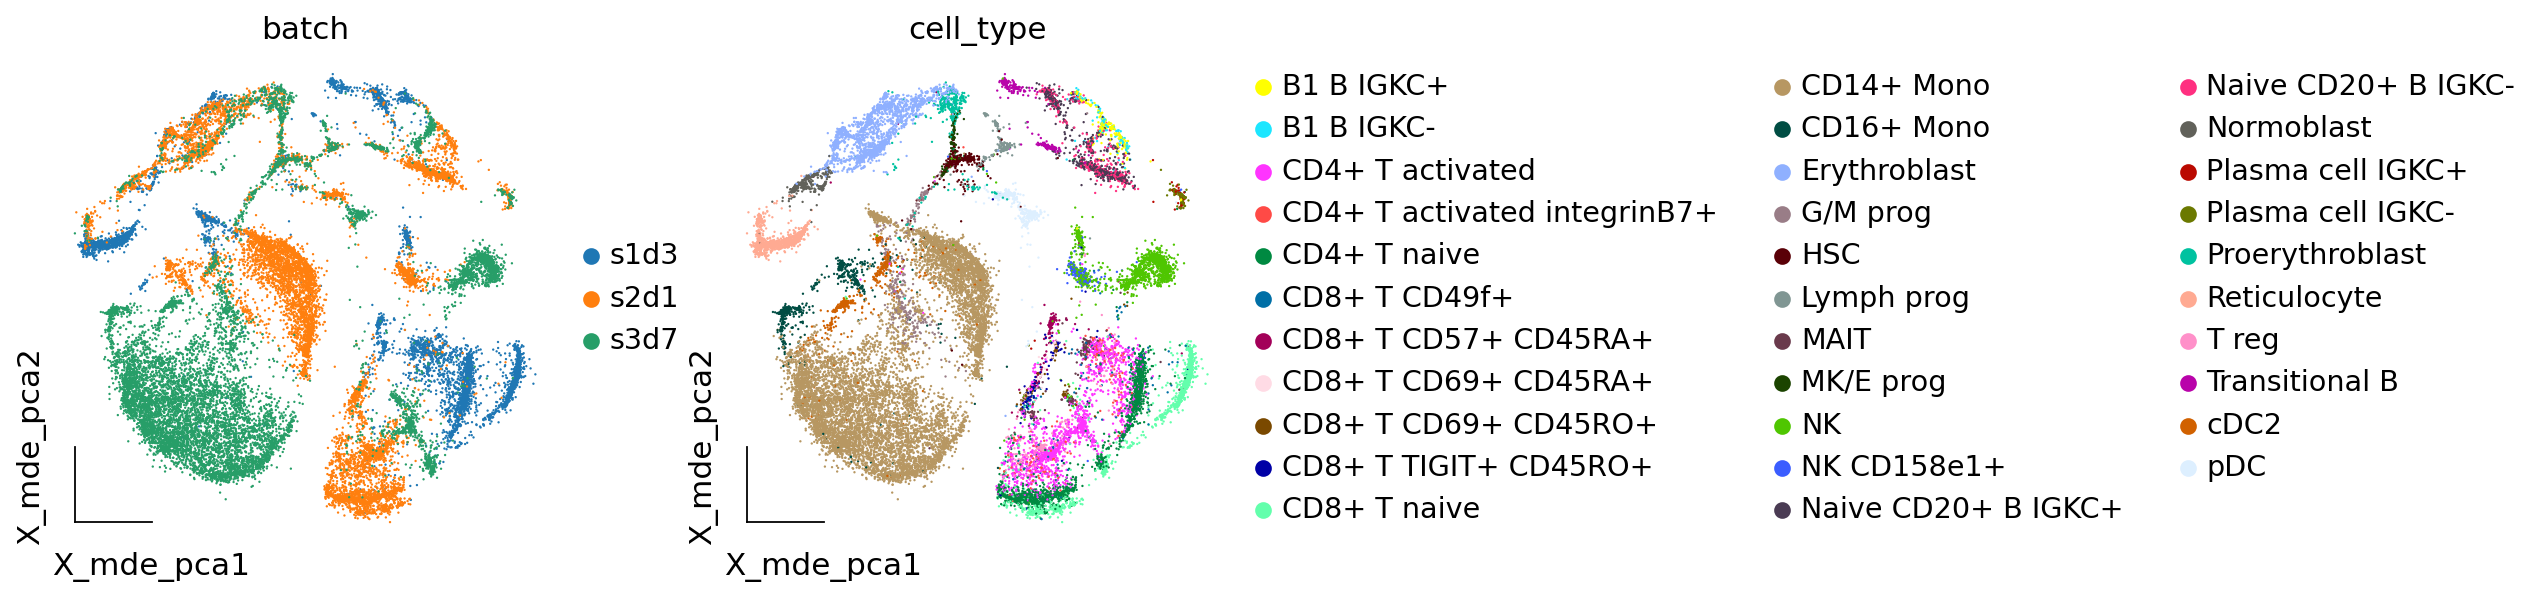

In [6]:
ov.utils.embedding(adata,
                basis='X_mde_pca',frameon='small',
                color=['batch','cell_type'],show=False)

## 5. 全局模型

我们要尝试的第一个批次效应的算法是基于全局模型的combat，我们在omicverse中重载了该算法，并提供了简单的函数借口进行调用。关于combat的更多介绍感兴趣的读者可以去阅读相关的论文。

In [7]:
adata_combat=ov.single.batch_correction(adata,batch_key='batch',
                                        methods='combat',n_pcs=50)
adata

Standardizing Data across genes.

Found 3 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



AnnData object with n_obs × n_vars = 26970 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'n_genes', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_features'
    uns: 'scrublet', 'layers_counts', 'log1p', 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'batch_colors', 'ce

我们可视化Combat后的批次效应校正结果。我们发现样本中还是存在着比较明显的批次效应，这表明Combat可能不太适用于我们的骨髓数据集。

[<AxesSubplot: title={'center': 'batch'}, xlabel='X_mde_combat1', ylabel='X_mde_combat2'>,
 <AxesSubplot: title={'center': 'cell_type'}, xlabel='X_mde_combat1', ylabel='X_mde_combat2'>]

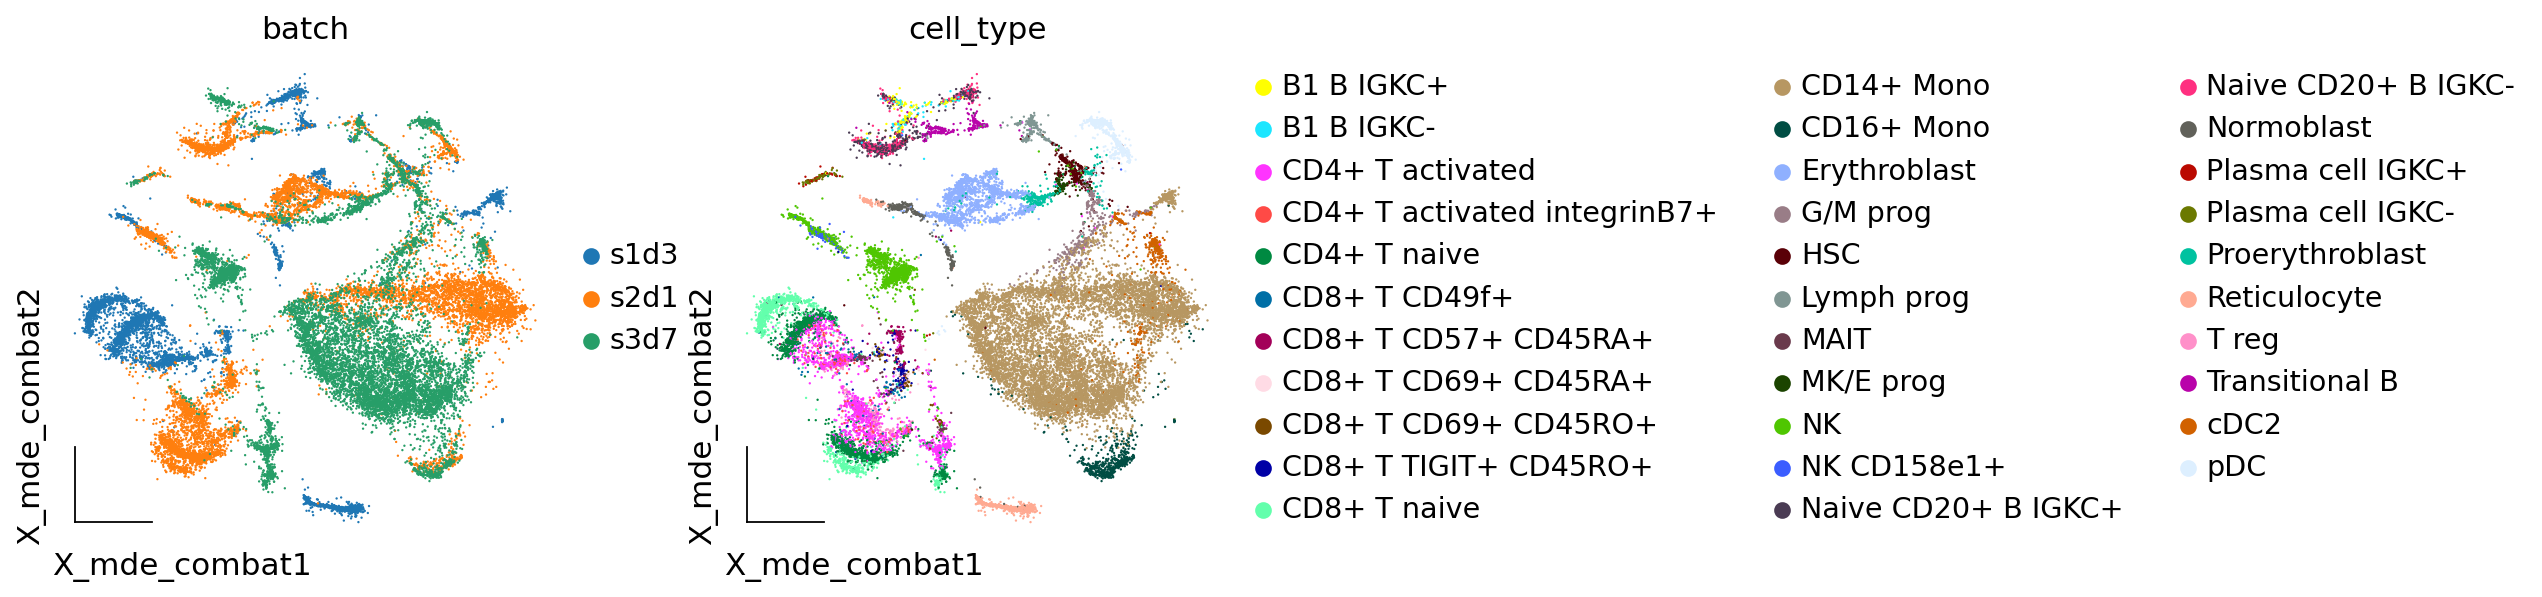

In [8]:
adata.obsm["X_mde_combat"] = ov.utils.mde(adata.obsm["X_combat"])
ov.utils.embedding(adata,
                basis='X_mde_combat',frameon='small',
                color=['batch','cell_type'],show=False)

## 6. 线性嵌入模型

线性嵌入模型我们一共会使用Harmony与scanorama来进行演示。我们首先介绍的是Harmony

### 6.1 Harmony

Harmony，是一种稳健、可扩展且灵活的多数据集集成算法，可满足无监督 scRNAseq 联合嵌入的四个关键挑战：扩展到大型数据集、识别广泛群体和细粒度子群体、适应复杂实验的灵活性设计以及跨模式整合的能力。

![Harmony](https://portals.broadinstitute.org/harmony/articles/main.jpg)

In [9]:
adata_harmony=ov.single.batch_correction(adata,batch_key='batch',
                                        methods='harmony',n_pcs=50)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2023-08-10 21:03:03,599 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-08-10 21:03:09,288 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-08-10 21:03:09,444 - harmonypy - INFO - Iteration 1 of 10
2023-08-10 21:03:15,470 - harmonypy - INFO - Iteration 2 of 10
2023-08-10 21:03:21,530 - harmonypy - INFO - Iteration 3 of 10
2023-08-10 21:03:28,488 - harmonypy - INFO - Iteration 4 of 10
2023-08-10 21:03:34,733 - harmonypy - INFO - Iteration 5 of 10
2023-08-10 21:03:41,025 - harmonypy - INFO - Iteration 6 of 10
2023-08-10 21:03:47,371 - harmonypy - INFO - Iteration 7 of 10
2023-08-10 21:03:53,738 - harmonypy - INFO - Iteration 8 of 10
2023-08-10 21:03:59,959 - harmonypy - INFO - Iteration 9 of 10
2023-08-10 21:04:06,248 - harmonypy - INFO - Iteration 10 of 10
2023-08-10 21:04:11,180 - harmonypy - INFO - Stopped before convergence


我们继续使用嵌入可视化来观察Harmony的结果，我们发现CD4+ Mono细胞中，s3d7和s2d1被很好地混合到了一起，看起来，样本的批次效应得到了很好的校正。

[<AxesSubplot: title={'center': 'batch'}, xlabel='X_mde_harmony1', ylabel='X_mde_harmony2'>,
 <AxesSubplot: title={'center': 'cell_type'}, xlabel='X_mde_harmony1', ylabel='X_mde_harmony2'>]

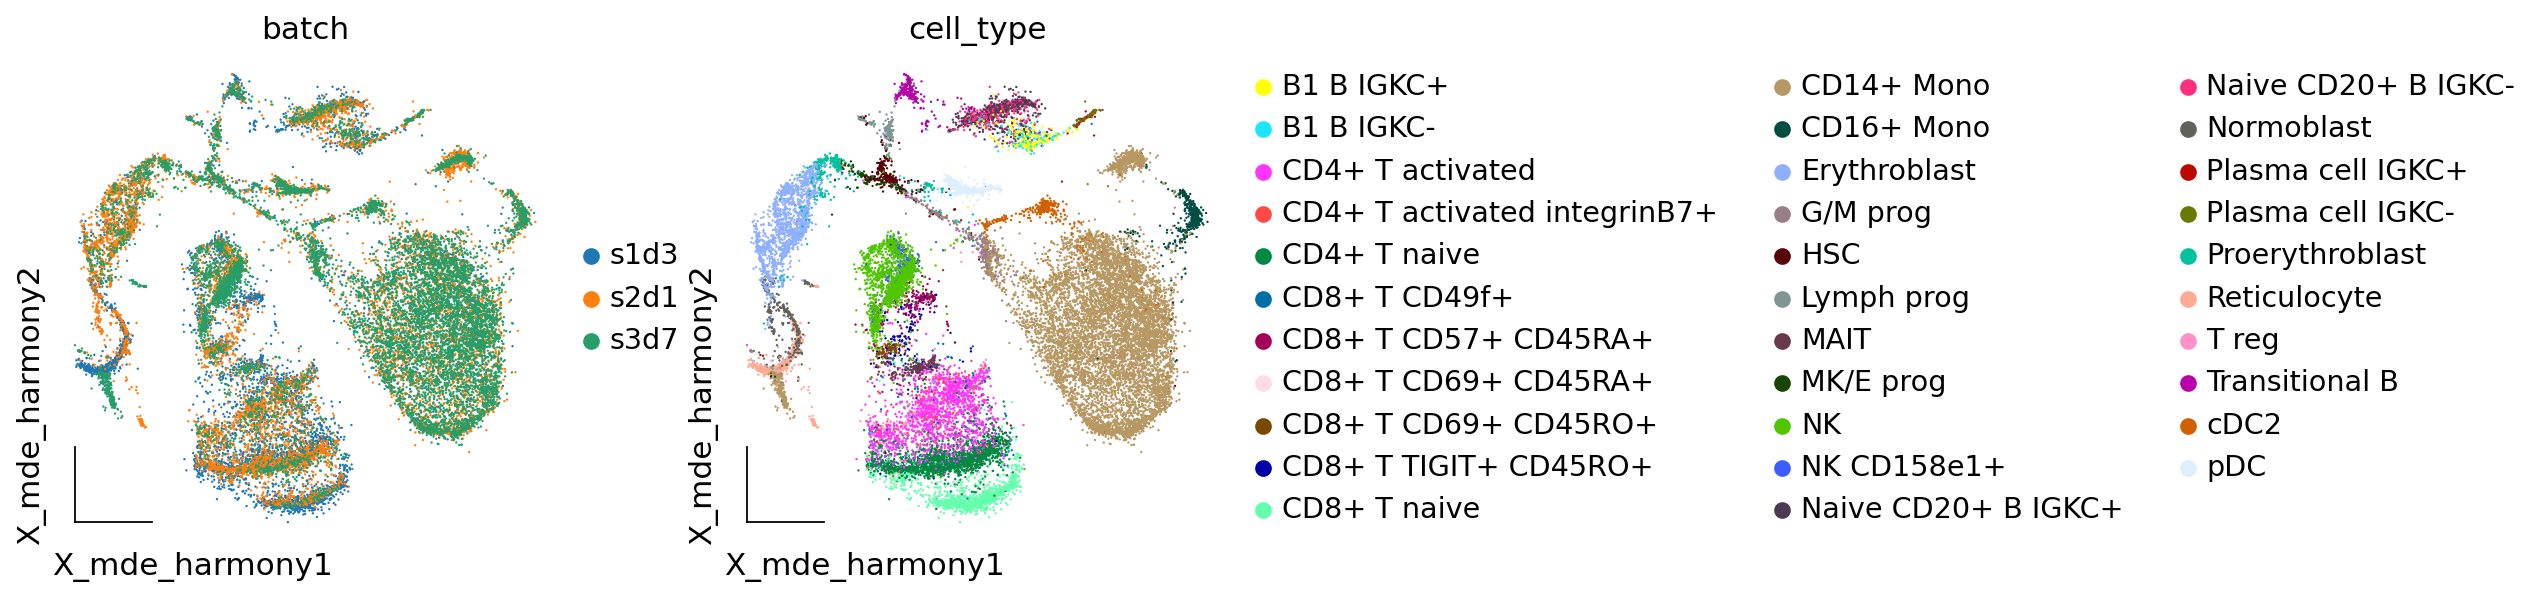

In [10]:
adata.obsm["X_mde_harmony"] = ov.utils.mde(adata.obsm["X_harmony"])
ov.utils.embedding(adata,
                basis='X_mde_harmony',frameon='small',
                color=['batch','cell_type'],show=False)

### 6.2 scanorama

Scanorama可以识别和合并共享的细胞类型之间的所有数据集和准确集成的 scRNA-seq 数据的异构集合。相似地，我们在omicverse也实现了scanorame的使用，也是通过batch_correction函数。


![scanorama](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41587-019-0113-3/MediaObjects/41587_2019_113_Fig1_HTML.png?as=webp)


In [11]:
adata_scanorama=ov.single.batch_correction(adata,batch_key='batch',
                                        methods='scanorama',n_pcs=50)

s1d3
s2d1
s3d7
Found 13953 genes among all datasets
[[0.         0.47831224 0.37535865]
 [0.         0.         0.75730994]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)
(26970, 50)


我们发现经过scanorama后的样本，批次效应也得到了很好地改善，那么Harmony和scanorama谁的效果会更好一些呢？我们在后面的章节中会对比不同的嵌入的效果，让我们继续看下一个

[<AxesSubplot: title={'center': 'batch'}, xlabel='X_mde_scanorama1', ylabel='X_mde_scanorama2'>,
 <AxesSubplot: title={'center': 'cell_type'}, xlabel='X_mde_scanorama1', ylabel='X_mde_scanorama2'>]

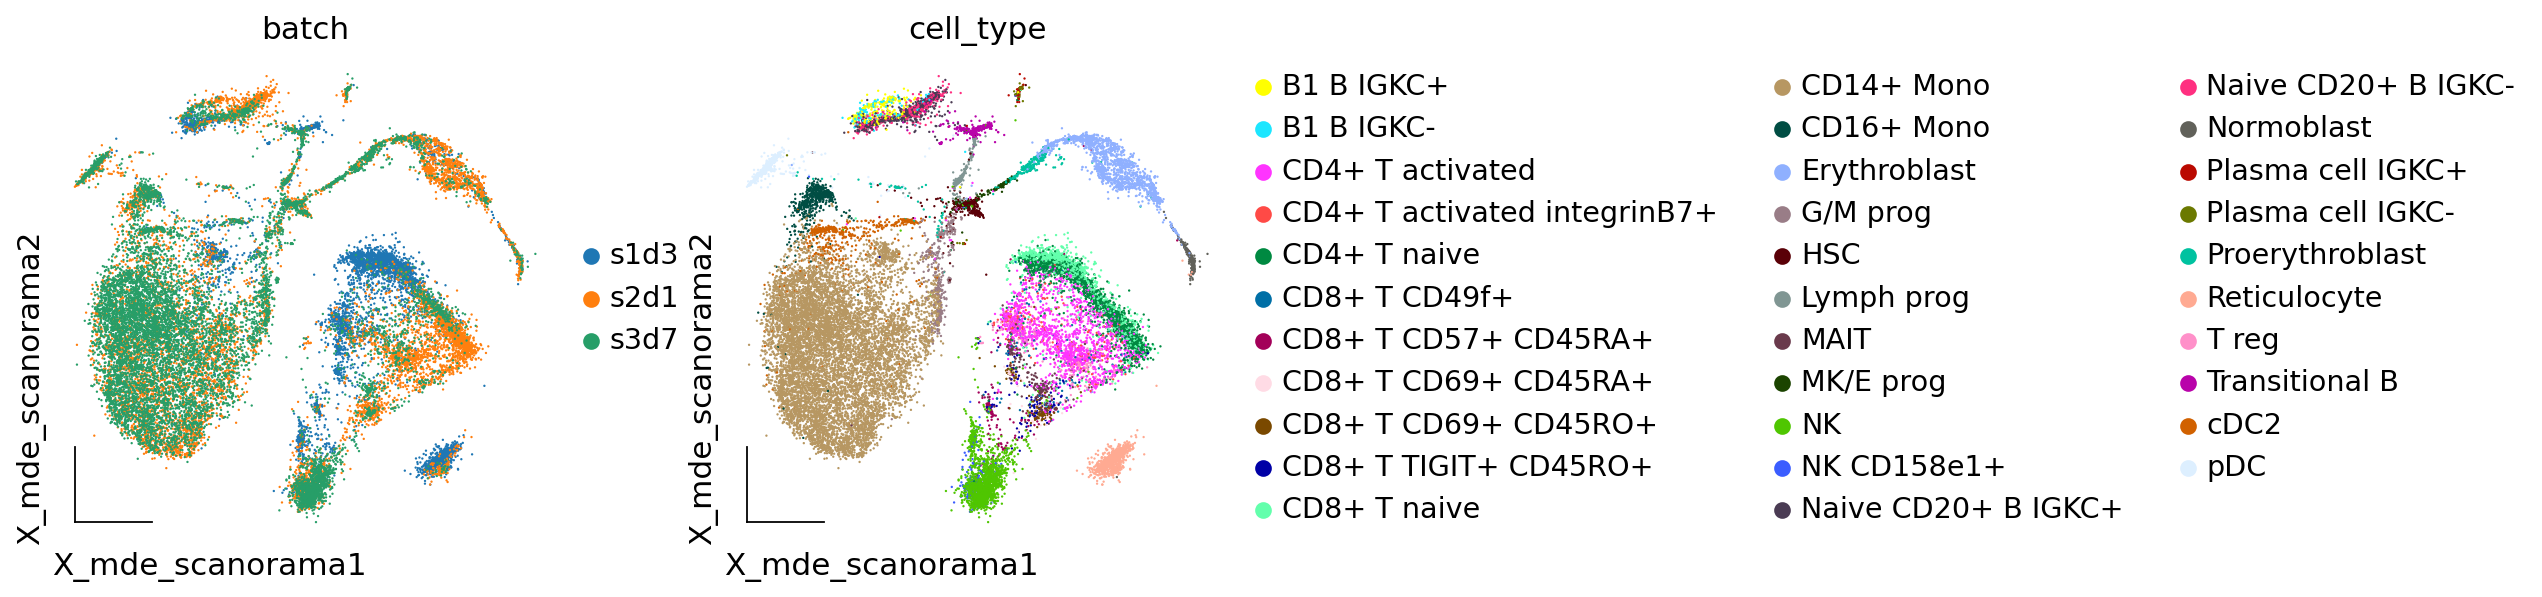

In [12]:
adata.obsm["X_mde_scanorama"] = ov.utils.mde(adata.obsm["X_scanorama"])
ov.utils.embedding(adata,
                basis='X_mde_scanorama',frameon='small',
                color=['batch','cell_type'],show=False)

## 7. 深度学习模型

## 7.1 基于变分自编码器的模型

scVI（单元变分推理），这是一种基于条件变分自动编码器的方法[ Lopez等人，2017]。，2018 ]可在scvi-tools包中使用[ Gayoso等人。，2022 ]。变分自动编码器是一种试图降低数据集维数的人工神经网络。条件部分是指在特定协变量（在本例中为batch）上调节此降维过程，以便协变量不会影响低维表示。在基准研究scVI已被证明在一系列数据集上表现良好，在批次校正之间取得了良好的平衡，同时保留了生物变异性[ Luecken等人。，2021 ]。scVI直接对原始计数进行建模，因此为它提供计数矩阵而不是归一化表达矩阵非常重要。


In [14]:
adata1=adata.copy()
scvi.model.SCVI.setup_anndata(adata1, layer="counts", batch_key="batch")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


scVI创建的字段以_scvi. 这些是专为内部使用而设计的，不应手动修改。scvi-tools作者的一般建议是在模型训练完成之前不要对我们的对象进行任何更改。在其他数据集上，您可能会看到有关包含非标准化计数数据的输入表达矩阵的警告。这通常意味着您应该检查提供给设置函数的层adata.layers是否确实包含`Counts`。但如果您对来自全长协议或来自另一种不产生的定量方法的数据执行基因长度校正而获得的值，也可能会发生这种情况整数计数。

In [15]:
vae = scvi.model.SCVI(adata1, n_layers=2, n_latent=30, gene_likelihood="nb")
vae

SCVI Model with the following params: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

我们在准备好数据与模型后，就开始训练了，默认情况下，scVI使用以下启发式方法来设置纪元数。对于细胞数少于 20,000 个的数据集，将使用 400 个 epoch，随着细胞数量增加到 20,000 以上，epoch 的数量会不断减少。这背后的原因是，当模型在每个epoah看到更多的barcodes时，它可以学到与从更多batch和更少的barcodes的信息中学到相同的信息量。

In [116]:
vae.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 297/297: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [06:56<00:00,  1.39s/it, v_num=1]

INFO: `Trainer.fit` stopped: `max_epochs=297` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=297` reached.


Epoch 297/297: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [06:56<00:00,  1.40s/it, v_num=1]


我们使用vae.get_latent_representation来获取批次效应校正后的降维结果。

In [ ]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

与线性嵌入的模型整合方法类似，scVI也取得了比较好的批次效应校正结果。

[<AxesSubplot: title={'center': 'batch'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>,
 <AxesSubplot: title={'center': 'cell_type'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>]

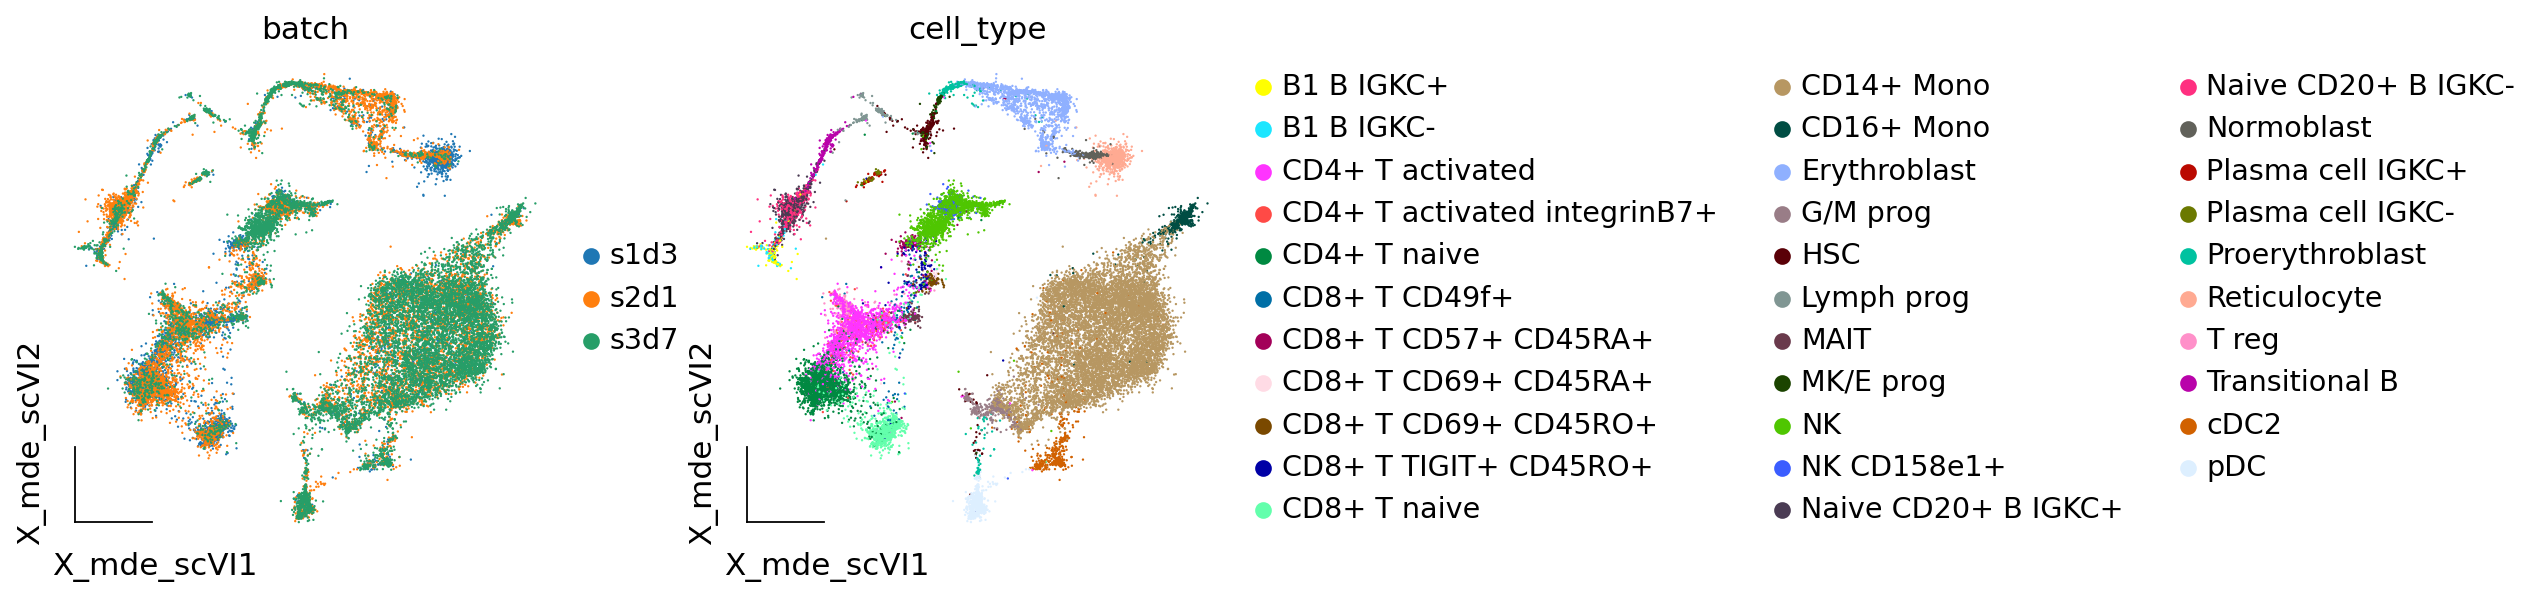

In [17]:
adata.obsm["X_mde_scVI"] = ov.utils.mde(adata.obsm["X_scVI"])
ov.utils.embedding(adata,
                basis='X_mde_scVI',frameon='small',
                color=['batch','cell_type'],show=False)

### 7.2 使用细胞标签的先验知识进行 VAE 集成

当我们使用scVI进行数据集成时，我们其实是还没有任何的细胞标签（尽管我们在图中显示了它们）。但在某些情况下，我们确实提前了解了有关细胞类型的身份。最常见的是当我们想要将一个或多个公开可用的数据集与一项新研究的数据结合起来时。

而当我们有一些细胞的标签时，我们可以使用scANVI（使用变分推理的单细胞注释）]。这是scVI的扩展可以合并细胞身份标签信息以及批次信息的模型。因为额外细胞标签的信息，所以它可以尝试保留细胞标签之间的差异，同时消除批次效应。基准测试表明，与scVI相比，scANVI往往能更好地保留生物信号，但有时它在消除批次效应方面并不那么有效。虽然我们在这里为所有细胞提供了标签，但也可以以半监督方式使用scANVI，例如我们仅为某些细胞提供标签。

> 标签统一
> 如果您使用scANVI来集成已有标签的多个数据集，那么首先执行标签统一非常重要。这是指检查标签在正在集成的数据集中是否一致的过程。例如，一个细胞在一个数据集中可能被注释为“T 细胞”，但同一类型的细胞在另一个数据集中可能被赋予标签“CD8+ T 细胞”。如何最好地统一标签是一个悬而未决的问题，一般来说我们可以根据我们的任务来确定，统一为主要的细胞类型是一种比较常见的策略。

我们首先创建一个scANVI模型对象。请注意，由于scANVI改进了已训练的scVI模型，因此我们提供 scVI 模型而不是 AnnData 对象。如果我们还没有训练scVI模型，我们需要首先训练。我们还需要提供为标注的细胞信息，在这里我们所有细胞都已经标注了所以可以忽略，通常来说我们会命名为`Unknown`或者`Unlabelled`.

In [19]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata1,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)

In [20]:
lvae

ScanVI Model with the following params: 
unlabeled_category: Unknown, n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Not Trained
Model's adata is minified?: False

In [121]:
lvae.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.40s/it, v_num=1]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.40s/it, v_num=1]


我们可以从模型中提取新的潜在表示并创建新的 UMAP 嵌入，就像我们对scVI所做的那样。

In [ ]:
adata.obsm["X_scANVI"] = lvae.get_latent_representation()

我们发现scANVI对于批次效应的校正，也有比较好的效果。

[<AxesSubplot: title={'center': 'batch'}, xlabel='X_mde_scANVI1', ylabel='X_mde_scANVI2'>,
 <AxesSubplot: title={'center': 'cell_type'}, xlabel='X_mde_scANVI1', ylabel='X_mde_scANVI2'>]

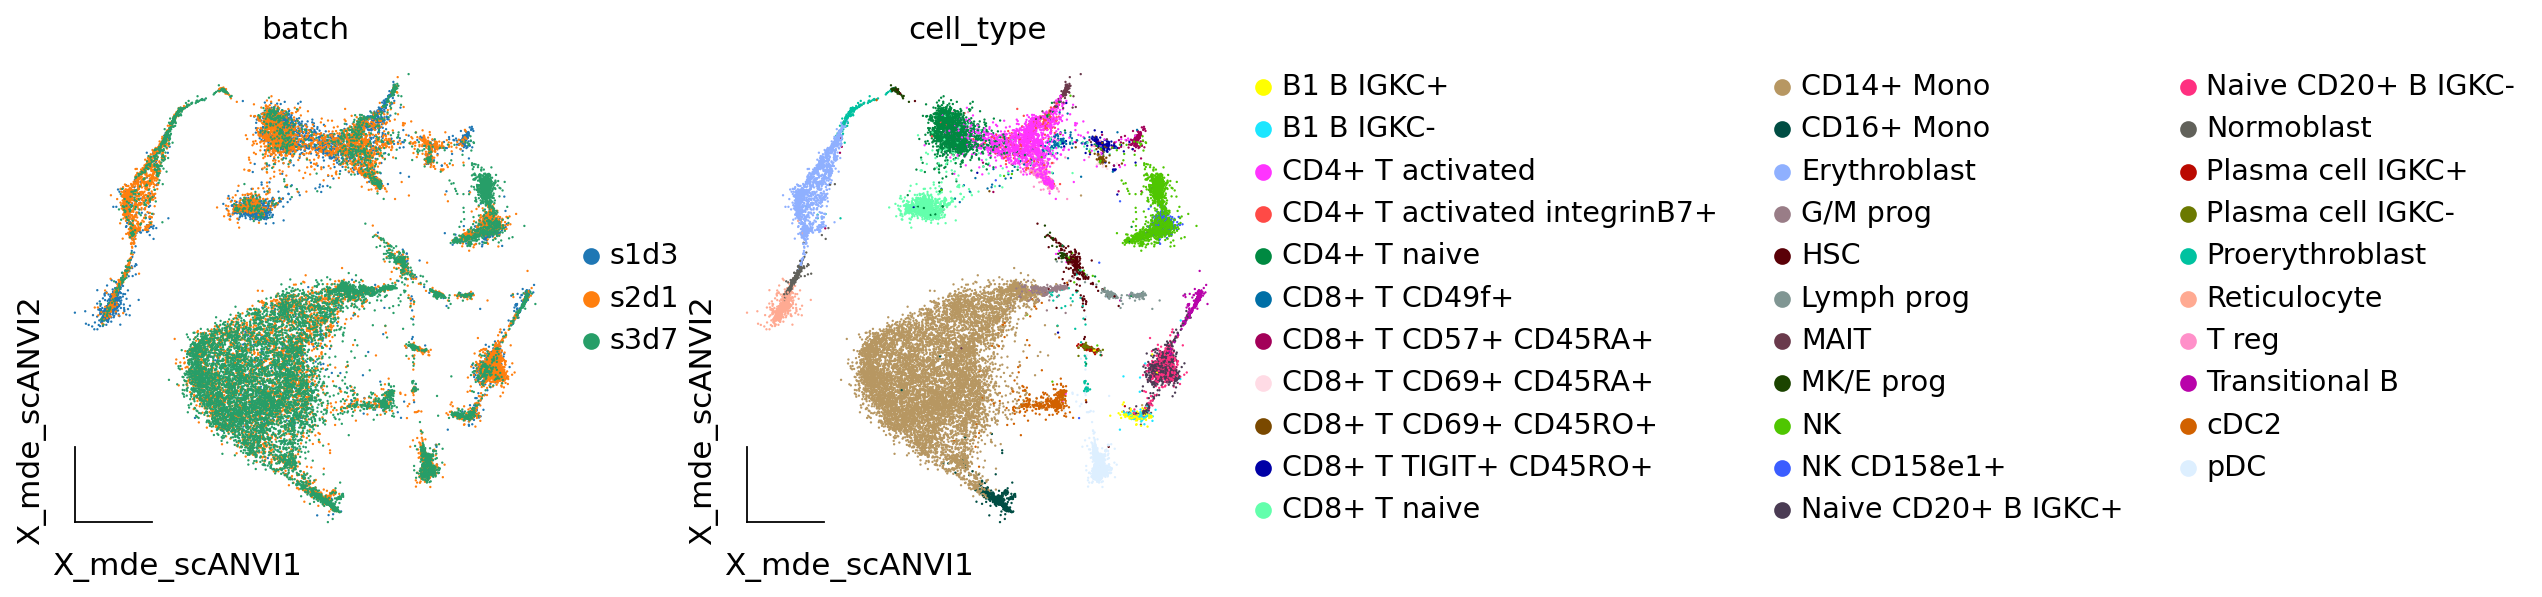

In [21]:
adata.obsm["X_mde_scANVI"] = ov.utils.mde(adata.obsm["X_scANVI"])
ov.utils.embedding(adata,
                basis='X_mde_scANVI',frameon='small',
                color=['batch','cell_type'],show=False)

### 7. 基于细胞与特征共嵌入图

随着单细胞数据收集在多个机构之间的扩展，对能够说明技术协变量的分析方法的需求也在增加。批量校正是在保留生物信号的同时消除技术差异的关键。然而，现有的方法是依赖于聚类，并且标记的检测容易发生不一致时，组合基因鉴定从未校正的空间的每一批。相比之下，SIMBA 产生细胞和基因的嵌入，使批效应去除和标记基因检测在一个集成的空间没有聚类。

In [129]:
workdir = 'simba_test'
adata6=adata.copy()
simba_object=ov.single.pySIMBA(adata6,workdir)

simba have been install version: 1.2


simba也可以要求使用高可变基因进行预处理，由于我们在最前面的分析中已经完成，所以可以看到这里在每个batch里选取的都与我们此前选取的一致。

In [130]:
simba_object.preprocess(batch_key='batch',min_n_cells=3,
                    method='lib_size',n_top_genes=3000,n_bins=5)

Before filtering: 
5925 cells, 3000 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
5925 cells, 3000 genes
3000 variable genes are selected.
Before filtering: 
10101 cells, 3000 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
10101 cells, 3000 genes
3000 variable genes are selected.
Before filtering: 
10944 cells, 3000 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
10944 cells, 3000 genes
3000 variable genes are selected.


In [131]:
simba_object.gen_graph()

#shared features: 3000
Performing randomized SVD ...
Searching for mutual nearest neighbors ...
36733 edges are selected
#shared features: 3000


/mnt/data/env/pyomic/lib/python3.8/site-packages/simba/tools/_integration.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_ref_query = ad.AnnData(X=sim_ref_query,


Performing randomized SVD ...
Searching for mutual nearest neighbors ...
71900 edges are selected


/mnt/data/env/pyomic/lib/python3.8/site-packages/simba/tools/_integration.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_ref_query = ad.AnnData(X=sim_ref_query,


relation0: source: C, destination: G
#edges: 538584
relation1: source: C, destination: G
#edges: 1556680
relation2: source: C, destination: G
#edges: 905079
relation3: source: C, destination: G
#edges: 381587
relation4: source: C, destination: G
#edges: 165569
relation5: source: C2, destination: G
#edges: 640073
relation6: source: C2, destination: G
#edges: 1415428
relation7: source: C2, destination: G
#edges: 1769245
relation8: source: C2, destination: G
#edges: 940121
relation9: source: C2, destination: G
#edges: 96342
relation10: source: C3, destination: G
#edges: 740720
relation11: source: C3, destination: G
#edges: 2071235
relation12: source: C3, destination: G
#edges: 1882114
relation13: source: C3, destination: G
#edges: 1168734
relation14: source: C3, destination: G
#edges: 331335
relation15: source: C3, destination: C
#edges: 36733
relation16: source: C3, destination: C2
#edges: 71900
Total number of edges: 14711479
Writing graph file "pbg_graph.txt" to "./result_simba/pbg/gra

In [ ]:
simba_object.train(num_workers=6)

In [ ]:
adata2=simba_object.batch_correction()
adata.obsm['X_simba']=adata2.obsm['X_simba'].copy()

我们发现，SIMBA的效果似乎不如前面的算法要好，它将样本的细胞类型信息当成了生物学差异一并消除了，这或许是因为simba的任务设计并不是特定于批次效应的校正。

[<AxesSubplot: title={'center': 'batch'}, xlabel='X_mde_simba1', ylabel='X_mde_simba2'>,
 <AxesSubplot: title={'center': 'cell_type'}, xlabel='X_mde_simba1', ylabel='X_mde_simba2'>]

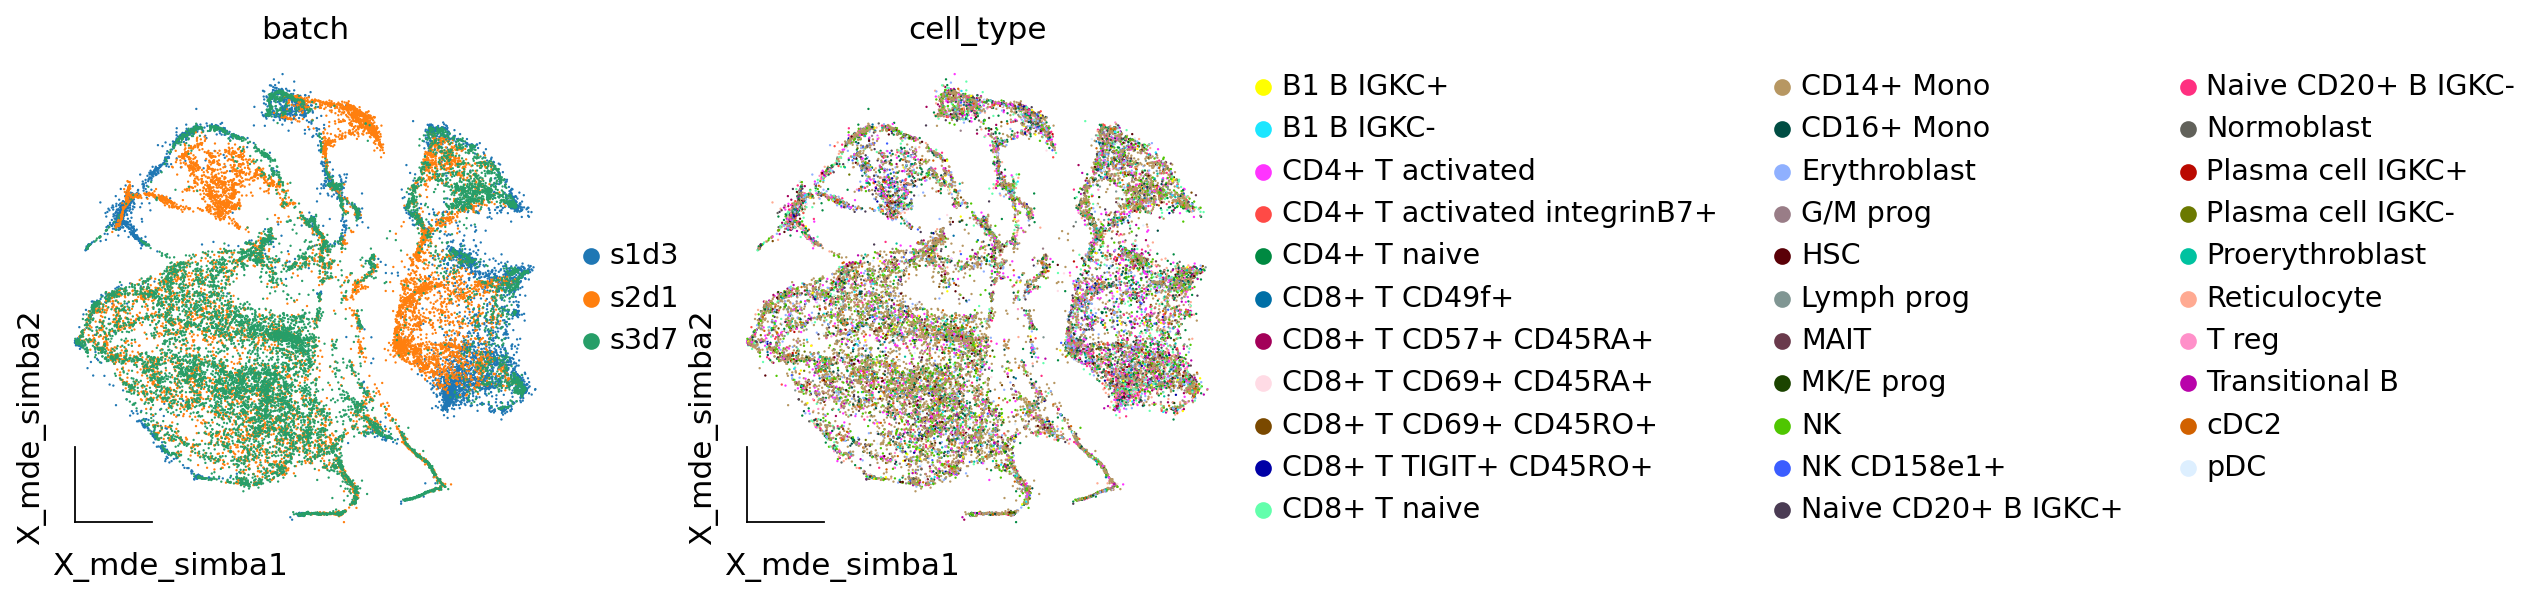

In [22]:
adata.obsm["X_mde_simba"] = ov.utils.mde(adata.obsm["X_simba"])
ov.utils.embedding(adata,
                basis='X_mde_simba',frameon='small',
                color=['batch','cell_type'],show=False)

## 8. 不同批次效应校正算法的对比。

通常来说，比较不同算法的过程我们会称之为基准测试，在这里，我们将使用scib包来执行这一过程。

In [ ]:
adata.obsm['X_pca']=adata1.obsm['scaled|original|X_pca'].copy()
from scib_metrics.benchmark import Benchmarker
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", "X_combat", "X_harmony",
                         'X_scanorama','X_scVI','X_scANVI','X_simba'],
    n_jobs=8,
)
bm.benchmark()

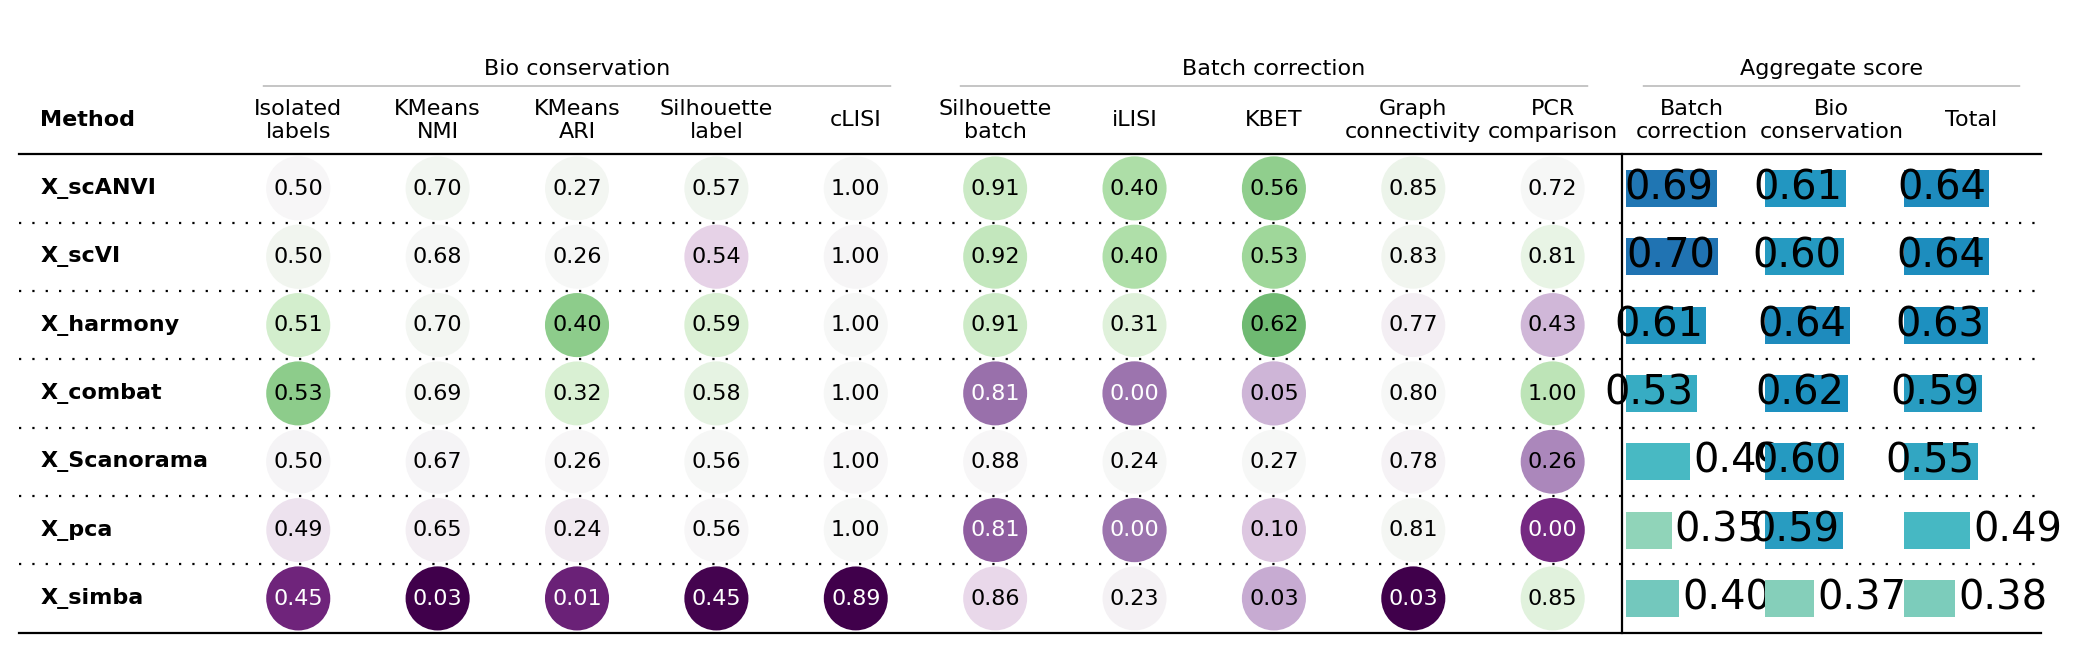

In [140]:
bm.plot_results_table(min_max_scale=False)

我们发现，对于批次效应的去除，scANVI和scVI都保持着最高的水准，但他们的计算都需要用到GPU，而对不使用GPU的批次效应校正算法，Harmony体现出了最好的效果。我们在这里介绍不同指标的含义。

### 8.1 Batch correction

1. Average silhouette width (ASW): 平均轮廓宽度。这是一种用于评估聚类质量的指标，用于衡量细胞在不同批次中是否能够被正确地分开
2. Graph integration local inverse Simpson’s Index (graph iLISI): 图集成局部倒数Simpson指数。这似乎是一种用于比较不同图谱（可能是从不同批次收集的）之间差异的方法，可能是通过比较细胞类型或样本之间的相似性来完成的。
3. k-nearest-neighbor batch effect test (kBET): k最近邻批次效应检验。这是一种用于衡量数据集中不同批次之间是否存在批次效应的统计方法。
4. k-nearest-neighbor (kNN) graph connectivity: k最近邻图连通性。这可能涉及构建一个基于细胞之间相似性的图，以衡量不同批次之间的连接性。

### 8.2 Bio conservation

1. Isolated label scores: 孤立标签分数。用于评估罕见细胞身份标签的指标。
2. Normalized Mutual Information (NMI): 归一化互信息。用于测量两个随机变量之间关联度的度量。在这里我们测量不同batch校正后细胞类型的一致性
3. Adjusted Rand Index (ARI): 调整兰德指数。一种用于比较两个数据分区的相似度的指标。
4. Average silhouette width (ASW): 平均轮廓宽度。这是一种用于评估聚类质量的指标，用于衡量不同细胞类型中是否能够被正确地分开
5. graph cLISI: cLISI。可能是一种用于衡量标签保守性的统计方法，可能与细胞之间的相似性有关。

## 9. 思考

- 为什么要校正批次效应？批次效应不校正会有什么后果？
- 我们可以使用哪些方法校正批次效应？除了教程里所提到的方法外，你还能找到更多批次效应校正的算法吗？
- 使用GPU和不使用GPU的批次效应校正算法区别在哪里？
- 为什么SIMBA批次效应校正的效果比较差？
